# Introduction

The following cells should contain all already completed steps to obtain the leading eigenvalue from the linearized Eliashberg equations through the particle-particle vertex when obtained from lDGA.

All unverified (yet yto be tested) and potentially unimplemented parts are described in the comments.


# Setup

## Packages

The following steps are automatically executed in one of the following cells.

You need the following source codes:

    - https://github.com/atomtomate/VertexPostprocessing.jl
    - https://github.com/atomtomate/LadderDGA.jl

In order to install these packages without dependency issues, first add my private registry with

```
using Pkg
pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
```

Some Julia versions and operating systems experience problems with SSL certificates. A temporary workaround is to immediately after starting Julia, set the `ENV` variables 

```
ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
```

It is also sometimes necessary to delete the `Manifest.toml` in custom repositories.

The following general Julia packages are required for this notebook:

    - Plots, LaTeXStrings, JLD2


## Data

We need the 2 particle GF in the form of the `2_part_gf_red` file as obtained from the new version of the Fortran code (<mark>you could try and rewrite the script to work with the `vert_chi` file; I have not tried that</mark>).

To expand this file, we need the `freqList.jld2` generated for this calculation (see `EquivalenceClassesConstructor.jl`).

<mark>In order to rule out errors in the index mappings, all results below should be calculated for two sets of inputs: shifted and non-shifted.</mark>


## Settings

Below, set:

    - dbgPkg to `true` if you have trouble with the package manager or not added my private registry.
    - `codeDir` variable to a directory that contains the LadderDGA.jl and VertexPostprocessing.jl codes (they have to be instantiated, as usual).
    - `dataDir` variable containing the `2_part_gf_red` files

In [7]:
codeDir = "G:/Codes/"
dataDir = "G:/Hamburg/b20.0_mu1.0"
dbgPkg = true

true

In [8]:
using Pkg

Pkg.add(["Plots", "LaTeXStrings", "JLD2"])
using Plots, LaTeXStrings


if dbgPkg
    ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
    ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
    pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
end

Pkg.activate(joinpath(codeDir,"VertexPostprocessing.jl/"))
Pkg.instantiate()
using VertexPostprocessing

Pkg.activate(joinpath(codeDir,"LadderDGA.jl"))
Pkg.instantiate()
using LadderDGA



     Cloning registry from "https://github.com/Atomtomate/JuliaRegistry.git"
Registry `JuliaRegistry` already exists in `C:\Users\Atomt\.julia\registries\JuliaRegistry`.
  Activating project at `G:\Codes\VertexPostprocessing.jl`
  Activating project at `G:\Codes\LadderDGA.jl`
   Resolving package versions...
      Compat entries added for 
  No Changes to `G:\Codes\LadderDGA.jl\Project.toml`
  No Changes to `G:\Codes\LadderDGA.jl\Manifest.toml`


In [9]:
Pkg.add(["Plots", "LaTeXStrings"])

   Resolving package versions...
      Compat entries added for 
  No Changes to `G:\Codes\LadderDGA.jl\Project.toml`
  No Changes to `G:\Codes\LadderDGA.jl\Manifest.toml`


# Expand Vertex

## Introduction

This part of the code is responsible for generating the input for lDGA from the `2_part_gf_red` using index mappings and the local BSE.
<mark>Check that the quantities are generated correctly, as an example the asymptotic behavior is investigated below.</mark>

We use the `expand_vertex.jl` script from `VertexPostprocessing.jl`. 
All potential fixes should be done in the corresponding routines of that package.
Adjust the `legacy_mode` (`true` when reading the `vert_chi` instead `2_part_gf_red`) and `fname` variables according to the test you are running.

More details can be found in the `expand_pp_test` notebook of the `VertexPostprocessing.jl` project, which we execute now.

In [10]:
legacy_mode = "false"
ofname = "DMFT2_out.jld2"

empty!(ARGS)
push!(ARGS, joinpath(dataDir))
push!(ARGS, dataDir)
push!(ARGS, legacy_mode)
push!(ARGS, ofname)

include(joinpath(codeDir,"VertexPostprocessing.jl", "scripts", "expand_vertex.jl"))

Expanding Vertex
Done expanding!

  Activating project at `G:\Codes\VertexPostprocessing.jl`



Calculating single particle Green's function
mu = 1.0, U= 2.0, beta = 20.0, nden = 0.9980326521345348
andpar: 
 jED.AIMParams([1.259171386511115, -1.100273033431085, -0.104668102351259, 0.186193064407258], [-0.331184904160184, 0.286779667020919, 0.160271496244066, 0.20530350727996])
Calculating derived quantities. Rank 3 quantities have the index convention [ωm, νn, νpn]
Done with ph channel!
Done with pp channel!
 ϵₖ =    1.2592  -1.1003  -0.1047   0.1862
 Vₖ =   -0.3312   0.2868   0.1603   0.2053
   1. min(|Vₖ|)           = 0.160271496244066
   2. ∑Vₗ^2               = 0.25976250076998364
   3. min(|ϵₖ|)           = 0.104668102351259
   4. min(|ϵₖ - ϵₗ|)      = 0.290861166758517
   5. |GLoc - G0W|[ν]     = [NaN, NaN, NaN, NaN, NaN, NaN]
   6. |ΣImp - Σ_2part|[ν] = [0.00010951367183972566, 0.0001731447591625578, 0.00021719701197447827, 0.0002595531124962726, 0.00030348563526816456, 0.0003491098696213581]
   7. 6 (relative, %)     = [0.0045, 0.0069, 0.009, 0.0112, 0.0135, 0.0159]
Stor

150

In [11]:
legacy_mode = "false"
ofname = "DMFT2_out.jld2"

empty!(ARGS)
push!(ARGS, joinpath(dataDir))
push!(ARGS, dataDir)
push!(ARGS, legacy_mode)
push!(ARGS, ofname)

include(joinpath(codeDir,"VertexPostprocessing.jl", "scripts", "expand_vertex.jl"))

Expanding Vertex
Done expanding!

  Activating project at `G:\Codes\VertexPostprocessing.jl`



Calculating single particle Green's function
mu = 1.0, U= 2.0, beta = 20.0, nden = 0.9980326521345348
andpar: 
 jED.AIMParams([1.259171386511115, -1.100273033431085, -0.104668102351259, 0.186193064407258], [-0.331184904160184, 0.286779667020919, 0.160271496244066, 0.20530350727996])
Calculating derived quantities. Rank 3 quantities have the index convention [ωm, νn, νpn]
Done with ph channel!
Done with pp channel!
 ϵₖ =    1.2592  -1.1003  -0.1047   0.1862
 Vₖ =   -0.3312   0.2868   0.1603   0.2053
   1. min(|Vₖ|)           = 0.160271496244066
   2. ∑Vₗ^2               = 0.25976250076998364
   3. min(|ϵₖ|)           = 0.104668102351259
   4. min(|ϵₖ - ϵₗ|)      = 0.290861166758517
   5. |GLoc - G0W|[ν]     = [NaN, NaN, NaN, NaN, NaN, NaN]
   6. |ΣImp - Σ_2part|[ν] = [0.00010951367183972566, 0.0001731447591625578, 0.00021719701197447827, 0.0002595531124962726, 0.00030348563526816456, 0.0003491098696213581]
   7. 6 (relative, %)     = [0.0045, 0.0069, 0.009, 0.0112, 0.0135, 0.0159]
Stor

150

## Construction of Fpp

The notebook `Test_F_ladder_pp.ipynb` has details and tests for the functions that are used to construct Φs and Φt.

<mark>In this version of the code, there seems to be an error. I think this was not the case in lDGAPostprocessing.jl</mark>.

## Asymptotic Behavior

The asymptotic behavior is given here, the variables for diagonal and background are defined in the next cell.

<mark>Verify limit definition!</mark>

<mark>Verify indices for limits!</mark>

### $\Gamma$ 

$\Gamma^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

$\Gamma^{\nu\nu'\omega}_t \sim \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

### $F$

$F^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp} + U \lambda^{\nu\omega}_d + U \lambda^{\nu'\omega}_d + U^2 \chi^{\omega}_d$

$F^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp}  + U \lambda^{\nu\omega}_m + U \lambda^{\nu'\omega}_m + U^2 \chi^{\omega}_m$

$F^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} + 2U \lambda^{\nu\omega}_{pp,\uparrow\downarrow} + 2U \lambda^{\nu'\omega}_{pp,\uparrow\downarrow} + 2 U^2 \chi^{\omega}_{pp,\uparrow\downarrow}$

$F^{\nu\nu'\omega}_t \sim  \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m}$


In [43]:
# Print function
ωn = 0
ωi0 = nBose+1;
bg_ind = floor(Int, size(Fd,2)*(1.4/4))
nan_ind = trunc(Int,nBose/2+1)

# Print function
function format_out(val, lim; digits=5)
    lim_s = lpad(rpad(round(real(lim),digits=digits), 6, "0"),10, " ")
    val_s = lpad(rpad(round(real(val),digits=digits), 6, "0"),10, " ")
    sim = isapprox(val, lim, rtol=0.05) ? "\e[1m\e[38;2;0;150;50;249m✓\x1b[0m" :  "\e[1m\e[38;2;250;0;0;249m↯\x1b[0m"
    return "$val_s ≟ $lim_s  " * sim
end


# Definitions

Γd_lim_diag =  U + U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 
Γm_lim_diag = -U + U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 
Γs_lim_diag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2
Γt_lim_diag =    + U^2/2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2;

Γd_lim_bg =  U
Γm_lim_bg = -U
Γs_lim_bg = 2U
Γt_lim_bg = 0.0;

Fd_lim_diag =  U + U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_d_asympt[1]/β^2
Fm_lim_diag = -U + U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_m_asympt[1]/β^2
Fs_lim_diag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_diag =      U^2/2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2 ;

Fd_lim_bg =  U - 1 * U^2 * χ_d_asympt[1]/β^2 
Fm_lim_bg = -U - 1 * U^2 * χ_m_asympt[1]/β^2 
Fs_lim_bg = 2U - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_bg = 0.0;


# - compensates global -1 factor in script

println("                   numerical ≟ exact")
println("   ================ Γ ==================   ")
println("Diagonal Γd   :   $(format_out(Γd[ωi0,bg_ind,bg_ind] .* β^2 , Γd_lim_diag))")
println("Diagonal Γm   :   $(format_out(Γm[ωi0,bg_ind,bg_ind] .* β^2 , Γm_lim_diag))")
println("Diagonal Γs   :   $(format_out(Γs[ωi0,bg_ind,bg_ind]  .* β^2 , Γs_lim_diag))")
println("Diagonal Γt   :   $(format_out(Γt[ωi0,bg_ind,bg_ind]  .* β^2 , Γt_lim_diag))")

println("Background Γd :   $(format_out(Γd[ωi0,bg_ind,end-bg_ind] .* β^2, Γd_lim_bg))")
println("Background Γm :   $(format_out(Γm[ωi0,bg_ind,end-bg_ind] .* β^2, Γm_lim_bg))")
println("Background Γs :   $(format_out(Γs[ωi0,bg_ind,end-bg_ind]  .* β^2, Γs_lim_bg))")
println("Background Γt :   $(format_out(Γt[ωi0,bg_ind,end-bg_ind]  .* β^2, Γt_lim_bg))")

println("   ================ F ==================   ")
println("Diagonal Fd   :   $(format_out(Fd[ωi0,bg_ind,bg_ind], Fd_lim_diag))")
println("Diagonal Fm   :   $(format_out(Fm[ωi0,bg_ind,bg_ind], Fm_lim_diag))")
println("Diagonal Fs   :   $(format_out(Fs[ωi0,bg_ind,bg_ind] .* β^2, Fs_lim_diag))")
println("Diagonal Ft   :   $(format_out(Ft[ωi0,bg_ind,bg_ind] .* β^2, Ft_lim_diag))")

println("Background Fd :   $(format_out(Fd[ωi0,bg_ind,end-bg_ind], Fd_lim_bg))")
println("Background Fm :   $(format_out(Fm[ωi0,bg_ind,end-bg_ind], Fm_lim_bg))")
println("Background Fs :   $(format_out(Fs[ωi0,bg_ind,end-bg_ind].* β^2, Fs_lim_bg))")
println("Background Ft :   $(format_out(Ft[ωi0,bg_ind,end-bg_ind].* β^2, Ft_lim_bg))")

                   numerical ≟ exact
   ================ Γ ==================   
Diagonal Γd   :     39.44722 ≟   39.08795  ✓
Diagonal Γm   :    -13.94729 ≟  -14.09804  ✓
Diagonal Γs   :     41.40201 ≟   40.69103  ✓
Diagonal Γt   :     12.31491 ≟   12.49496  ✓
Background Γd :      2.06294 ≟     2.0000  ✓
Background Γm :     -1.67743 ≟     -2.000  ↯
Background Γs :      6.84147 ≟     4.0000  ↯
Background Γt :     -1.18121 ≟     0.0000  ↯
   ================ F ==================   
Diagonal Fd   :     38.69345 ≟   38.69103  ✓
Diagonal Fm   :    -38.69346 ≟  -38.69103  ✓
Diagonal Fs   :     40.32124 ≟   39.90621  ✓
Diagonal Ft   :     12.35266 ≟   12.49496  ✓
Background Fd :      1.67166 ≟    1.60308  ✓
Background Fm :     -26.3893 ≟    -26.593  ✓
Background Fs :      6.04542 ≟    3.21517  ↯
Background Ft :     -1.18898 ≟     0.0000  ↯


## Debug Plots

Below are some plots for the real and imaginary parts of F and Γ as a function of the fermionic frequencies. 
Adjust `ωn` to the Matsubaraindex (this is not the array index but the real one).

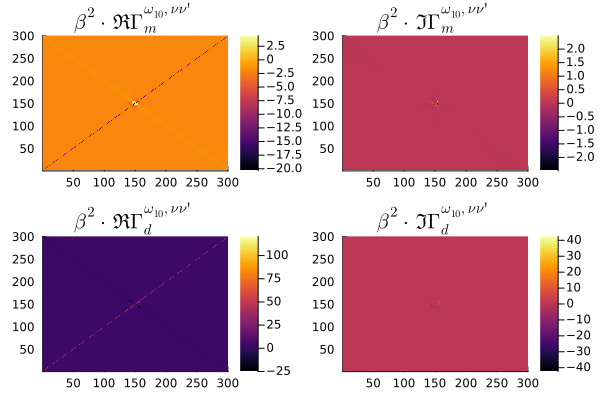

In [42]:
ωn = 10
p1 = heatmap(real(Γm[nBose + ωn, :, :] .* β^2), title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
p2 = heatmap(imag(Γm[nBose + ωn, :, :] .* β^2), title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
p3 = heatmap(real(Γd[nBose + ωn, :, :] .* β^2), title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
p4 = heatmap(imag(Γd[nBose + ωn, :, :] .* β^2), title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
plot(p1,p2,p3,p4)

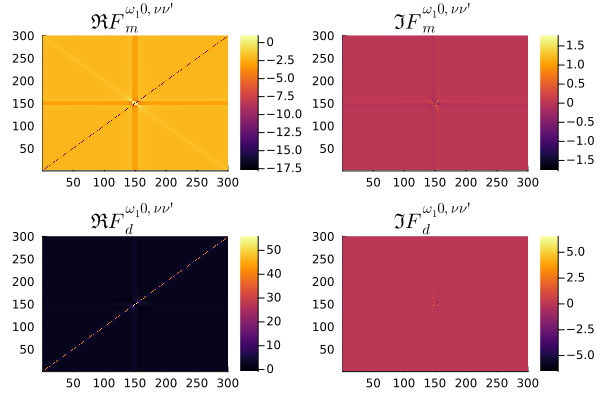

In [41]:
p1 = heatmap(real(Fm[nBose + ωn, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_m")
p2 = heatmap(imag(Fm[nBose + ωn, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_m")
p3 = heatmap(real(Fd[nBose + ωn, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_d")
p4 = heatmap(imag(Fd[nBose + ωn, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_d")
plot(p1,p2,p3,p4)

## Linearized Eliashberg Equations

### Equations

Equations should something like this:

$ \gamma^{\nu\omega}_{m/d,q} = \beta (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}\sum \chi^{\star,\nu\nu'\omega}_{m/d,q} \pm 1 $ 


$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1} 
            -  \beta^2 (\chi^{\nu\omega}_0)^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_0)^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \sum_{\nu_1\nu_2}\chi^{*,\nu\nu_1\omega}_{r,\mathbf{q}} \chi^{*,\nu_2\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} $

<mark>pm 1 missing</mark>

$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = 
            \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}
            -  \beta^2 (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\gamma^{\nu\omega}_r \mp 1) (\gamma^{\nu'\omega}_r \mp 1) $
        
$ F^{\nu\nu'\omega}_{r,\mathbf{q}} =
        \beta^2 \left( \chi^{\nu\nu'\omega}_{0,\mathbf{q}} \right)^{-1} 
        +  \beta^2 \left( \chi^{\nu\omega}_{0,\mathbf{q}} \right)^{-1}  \chi^{\nu\nu'\omega}_{r,\mathbf{q}} \left( \chi^{\nu'\omega}_{0,\mathbf{q}} \right)^{-1} $
        

$  F^{\nu\nu'\omega}_{\mathrm{ladder,ph,\uparrow\downarrow}, kk'q} =  \frac{1}{2} \left(
            F^{\lambda,\nu\nu'\omega}_{\mathrm{d},q}
            - F^{\lambda,\nu\nu'\omega}_{\mathrm{m},q} 
        \right) 
        - F^{\lambda,\nu(\omega+\nu)(\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu\nu'\omega}_{\mathrm{loc},\uparrow\downarrow} $

$ \Phi_{\uparrow\downarrow} = \frac{1}{2} (\Phi_\mathrm{s}  +\Phi_\mathrm{t})$

$  \Gamma^{\nu\nu'\omega}_{\mathrm{s},kk'q} := \Gamma^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\downarrow,kk'q} 
    = 
        F^{\nu'(-\nu)(\nu-\nu')}_{\mathrm{ladder},k'(-k)(k-k')} 
        - \Phi^{\nu\nu'\omega}_{\mathrm{loc},\mathrm{pp},\uparrow\downarrow,kk'q=0}  $
        
$\Gamma^{\nu\nu'\omega}_{s,kk'q} = \frac{1}{2} \left(
            F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{d},k-k'}
            - F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{m},k-k'} 
        \right) 
        - F^{\lambda,\nu'\nu(-\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu(-\nu)(\nu-\nu')}_{\mathrm{loc},\uparrow\downarrow} - \Phi^{\nu\nu'\omega}_{\mathrm{loc},\uparrow\downarrow}$

$ \lambda \Delta^{\nu}_{k} = -\frac{1}{\beta N_k} \sum_{\nu' k'} \Gamma^{\nu\nu'\omega=0}_{kk'q=0} \chi^{\nu'\omega_0}_{0,\mathrm{s},k'} \Delta^{\nu'}_{k'}$

`Test_F_ladder_pp.ipynb` has more details.


### Implementation

The file `src/LinearizedEliashberg.jl` in `LadderDGA.jl` implements this.

<mark>Check equations and implementation in `calc_Γs_ud` and `calc_λmax_linEliashberg`.</mark>

Remember that we need the particle-particle bubble here, which is computed with `build_GG`.

There are two versions of the function that calculates the leading eigenvalue: `calc_λmax_linEliashberg` and `calc_λmax_linEliashberg_MatrixFree`. 
One is matrix-free (i.e. Γs is not explicitly stored in memory, this is surprisingly fast) and one that uses subsampling in the q-space (remember to provide max_Nk, otherwise no subsampling is performed).